In [1]:
import os
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from mxnet.gluon import utils as gutils
from mxnet import image

data_dir = '../data/pikachu'
os.makedirs('data_dir', exist_ok=True)

In [2]:
def _download_pikachu(data_dir):
    root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
                'gluon/dataset/pikachu/')
    dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
               'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
               'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
    for k, v in dataset.items():
        gutils.download(root_url + k, os.path.join(data_dir, k), sha1_hash=v)

if not os.path.exists(os.path.join(data_dir, "train.rec")):
    print("下载原始数据集到%s..." % data_dir)
    _download_pikachu(data_dir)

In [3]:
def load_data_pikachu(batch_size, edge_size=256):  # edge_size：输出图像的宽和高
    train_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'train.rec'),
        path_imgidx=os.path.join(data_dir, 'train.idx'),
        batch_size=batch_size,
        data_shape=(3, edge_size, edge_size),  # 输出图像的形状
#         shuffle=False,  # 以随机顺序读取数据集
#         rand_crop=1,  # 随机裁剪的概率为1
        min_object_covered=0.95, max_attempts=200)
    val_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'val.rec'), batch_size=batch_size,
        data_shape=(3, edge_size, edge_size), shuffle=False)
    return train_iter, val_iter

In [4]:
batch_size, edge_size = 1, 256
train_iter, val_iter = load_data_pikachu(batch_size, edge_size)
batch = train_iter.next()
batch.data[0][0].shape, batch.label[0][0].shape

((3, 256, 256), (1, 5))

In [5]:
def process(data_iter, save_dir):
    """batch size == 1"""
    data_iter.reset() # 从头开始
    all_label = dict()
    id = 1
    os.makedirs(os.path.join(save_dir, 'images'), exist_ok=True)
    for sample in tqdm(data_iter):
        x = sample.data[0][0].asnumpy().transpose((1,2,0))
        plt.imsave(os.path.join(save_dir, 'images', str(id) + '.png'), x / 255.0)

        y = sample.label[0][0][0].asnumpy()

        label = {}
        label["class"] = int(y[0])
        label["loc"] = y[1:].tolist()

        all_label[str(id) + '.png'] = label.copy()

        id += 1

    with open(os.path.join(save_dir, 'label.json'), 'w') as f:
        json.dump(all_label, f, indent=True)

In [6]:
process(data_iter = train_iter, save_dir = os.path.join(data_dir, "train"))

900it [00:55, 16.09it/s]


In [7]:
process(data_iter = val_iter, save_dir = os.path.join(data_dir, "val"))

100it [00:06, 16.02it/s]


In [1]:
%matplotlib inline
import os
import json
import numpy as np
import torch
import torchvision
from PIL import Image

import sys
sys.path.append('..')
import d2lzh_pytorch as d2l

data_dir  = '../data/pikachu'

assert os.path.exists(os.path.join(data_dir, 'train'))

In [9]:
class PikachuDetDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, part, image_size=(256)):
        assert part in ['train', 'val']
        self.image_size = image_size
        self.image_dir = os.path.join(data_dir, part, 'images')
        
        with open(os.path.join(data_dir, part, 'label.json')) as f:
            self.label = json.load(f)
            
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor()
        ])
    
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, index):
        image_path =str(index + 1) + '.png'
        
        cls = self.label[image_path]['class']
        label = np.array([cls] + self.label[image_path]['loc'], dtype='float32')[None, :]
        
        PIL_img = Image.open(os.path.join(self.image_dir, image_path)).convert('RGB').resize(self.image_size)
        
        img = self.transform(PIL_img)
        
        sample = {
            'label': label,
            'image': img
        }
        
        return sample

In [10]:
def load_data_pikachu(batch_size, edge_size=256, data_dir='../data/pikachu'):
    image_size = (edge_size, edge_size)
    train_dataset = PikachuDetDataset(data_dir, 'train', image_size)
    test_dataset = PikachuDetDataset(data_dir, 'val', image_size)
    
    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=4)
    test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                            shuffle=False, num_workers=4)
    
    return train_iter, test_iter

In [11]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_pikachu(batch_size, edge_size, data_dir)
batch = iter(train_iter).next()
print(batch['image'].shape, batch['label'].shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 5])


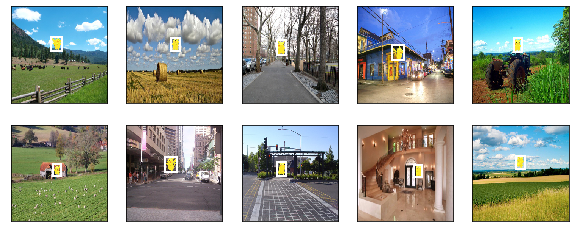

In [14]:
imgs = batch['image'][0:10].permute(0,2,3,1)
bboxes = batch['label'][0:10, 0, 1:]

axes = d2l.show_images(imgs, 2, 5).flatten()
for ax, bb in zip(axes, bboxes):
    d2l.show_bboxes(ax, [bb*edge_size],colors=['w'])

In [5]:
np.stack((a,a))

array([[1, 2, 3],
       [1, 2, 3]])